In [1]:
import os
import glob
import cv2
import tensorflow as tf

# physical_devices = tf.config.list_physical_devices('GPU')
# try:
#   tf.config.experimental.set_memory_growth(physical_devices[0], True)
#   print('Worked')
# except ValueError:
#   # Invalid device or cannot modify virtual devices once initialized.
#   pass

# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.compat.v1.Session(config=config)

try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except (AssertionError, ValueError, RuntimeError):
    raise RuntimeError('Unable to disable GPU')

import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

classes = ['mask', 'no_mask']

dim = 128
batch_size = 32
step_per_epoch = 10000//batch_size
#step_per_epoch = 1
epoch = 10

In [2]:
def read_img(file):
    img = tf.io.read_file(file)
    img = tf.image.decode_image(img, channels=3)
    #img.set_shape([None,None,3])
    img = tf.image.resize(img, [dim, dim])
    img = img/127.5-1
    return img

def load_set(path):
    mask_path = path + '/WithMask' + '/*.png'
    no_mask_path = path + '/WithoutMask' + '/*.png'
    img_list = []
    label_list = []
    for filename in glob.glob(mask_path): 
        img_list.append(read_img(filename))
    label_list += [0] * len(img_list)
    masked_len = len(img_list)
    
    for filename in glob.glob(no_mask_path):
        img_list.append(read_img(filename))
    label_list += [1] * (len(img_list) - masked_len)

    #shuffle
    temp = list(zip(img_list, label_list)) 
    random.shuffle(temp) 
    img_list, label_list = zip(*temp) 
    
    return list(img_list), list(label_list)

#Load Kaggle Dataset 
[training_img, training_labels] = load_set('../kaggle_12k/Train')
[validation_img, validation_labels] = load_set('../kaggle_12k/Validation')
#[test_img, test_labels] = load_set('../kaggle_12k/Test')
    

In [3]:
#From Tanya
def data_generator(features,labels):
  dataset = tf.data.Dataset.from_tensor_slices((features,labels))
  dataset = dataset.shuffle(buffer_size=100)
  autotune = tf.data.experimental.AUTOTUNE
  #dataset = dataset.map(load_data, num_parallel_calls=autotune)
  dataset = dataset.batch(batch_size=batch_size)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(autotune)
  return dataset

In [4]:
train_dataset = data_generator(training_img, training_labels)
validation_dataset = data_generator(validation_img, validation_labels)

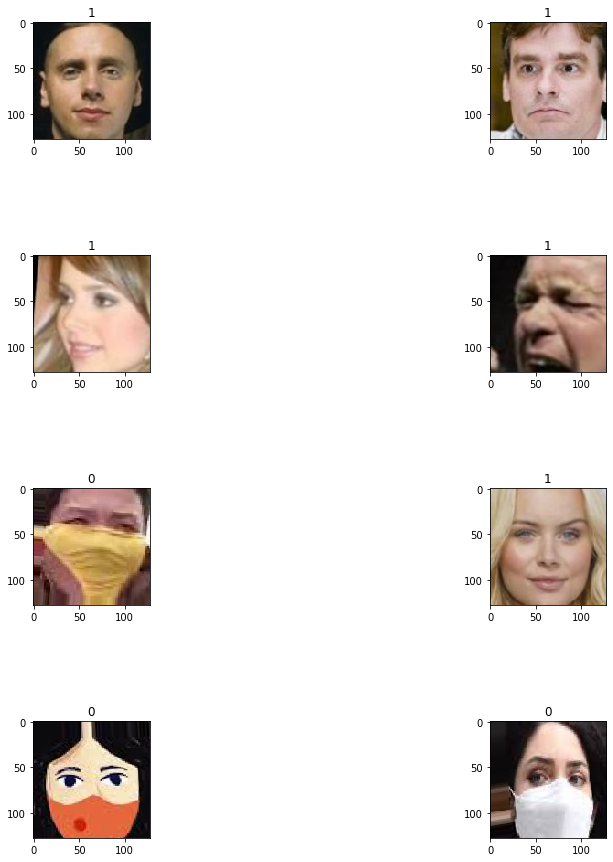

In [5]:
#Also Tanya
def show_img(dataset):
  plt.figure(figsize=(15,15))
  for i in range(8):
    for val in dataset.take(1):
      img  = (val[0][i]+1)*127.5
      plt.subplot(4,2,i+1)
      plt.imshow(tf.cast(img,tf.uint8))
      plt.title(val[1][i].numpy())
      plt.subplots_adjust(hspace=1)
  plt.show()

show_img(train_dataset)

In [8]:
def conv_model(num_blocks, rate, dim):
    
    input = tf.keras.layers.Input(shape=(dim,dim,3))
    
    x = tf.keras.layers.Conv2D(16, (8,8), strides=1)(input)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    for i in range(num_blocks-1):
        x = tf.keras.layers.Conv2D(8, (8,8), strides=1)(x)
        x = tf.keras.layers.Dropout(rate)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Lambda(lambda n: tf.keras.backend.expand_dims(n))(x)
        x = tf.keras.layers.Lambda(lambda n: tf.keras.backend.expand_dims(n))(x)
        x = tf.keras.layers.Activation('relu')(x)
        
    x = tf.keras.layers.Conv2D(filters=2, kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Dropout(rate)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GlobalMaxPooling2D()(x)
    predictions = tf.keras.layers.Activation('softmax')(x)
    
    model = tf.keras.Model(inputs=input, outputs=predictions)
    print(model.summary())
    
    return model


In [10]:
model = conv_model(2,.1, dim)
#model.load_weights('mask_classification_model.h5')
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('mask_classification_model.h5', 
                                       save_best_only=True, 
                                       save_weights_only=True,
                                       monitor='loss')]

model.fit(train_dataset,
          #batch_size=batch_size,
          epochs=epoch,steps_per_epoch=step_per_epoch,
          callbacks=callbacks)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 121, 121, 16)      3088      
_________________________________________________________________
dropout_4 (Dropout)          (None, 121, 121, 16)      0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 121, 121, 16)      64        
_________________________________________________________________
activation_4 (Activation)    (None, 121, 121, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 114, 114, 8)       8200      
_________________________________________________________________
dropout_5 (Dropout)          (None, 114, 114, 8)       0     

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(15,15))
for i in range(8):
  for val in validation_dataset.take(1):
    plt.subplot(4,2,i+1)
    img  = (val[0][i]+1)*127.5
    plt.imshow(tf.cast(img,tf.uint8))
    y_pred = model.predict(np.expand_dims(val[0][i],axis=0))
    y_pred = np.argmax(y_pred,axis=1)
    plt.title('Ground Truth{}, Predicted{}'.format(val[1][i],y_pred))
    plt.subplots_adjust(wspace=1, hspace=1)
plt.show()